In [ ]:
!nvidia-smi

Wed Aug 16 21:17:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Transform

In [ ]:
from torchvision import transforms

# input_size = desired size
def build_transform(is_train, input_size=224):
    ImageNet_mean = (0.485, 0.456, 0.406)
    ImageNet_std = (0.229, 0.224, 0.225)

    # train transform
    if is_train:
        transform = transforms.Compose([
            # 3 = PIL.Image.BICUBIC
            transforms.RandomResizedCrop(input_size, scale=(0.2, 1.0), interpolation=3),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(ImageNet_mean, ImageNet_mean),
        ])
        return transform

    # eval transform
    transform = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(ImageNet_mean, ImageNet_std),
    ])
    return transform

### Scheduler

In [ ]:
import torch

def init_lr_scheduler(
    optimizer,
    lr_scheduler,  # learning rate scheduler
    epochs,
    stepsize=[20, 40],  # step size to decay learning rate
    gamma=0.1,  # learning rate decay
    warmup_epochs=5,
    min_lr=0,
):
    '''
    Read https://github.com/pytorch/vision/blob/main/references/classification/train.py#L304
    and: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#lr-optimizations
    '''
    lr_warmup_decay = 0.01
    warmup_lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=lr_warmup_decay, total_iters=warmup_epochs
    )

    '''
    Read this line of code: https://github.com/pytorch/vision/blob/main/references/classification/train.py#L291
    and: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#:~:text=decaying%20the%20LR%20up%20to%20zero
    '''
    main_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs - warmup_epochs, eta_min=min_lr
    )

    if lr_scheduler == "single_step":
        return torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=stepsize[0], gamma=gamma
        )

    elif lr_scheduler == "multi_step":
        return torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=stepsize, gamma=gamma
        )

    elif lr_scheduler == "sequential":
        return torch.optim.lr_scheduler.SequentialLR(
            optimizer, schedulers=[warmup_lr_scheduler, main_lr_scheduler], milestones=[warmup_epochs]
        )
    else:
        raise ValueError(f"Unsupported lr_scheduler: {lr_scheduler}")

### Optimizer

In [ ]:
import torch

# Copyright (c) EEEM071, University of Surrey

import torch
import torch.nn as nn

def init_optimizer(
    model,
    optim="sgd",  # optimizer choices
    lr=0.5,  # learning rate
    weight_decay=2e-05,  # weight decay
    momentum=0.9,  # momentum factor for sgd and rmsprop
    sgd_dampening=0,  # sgd's dampening for momentum
    sgd_nesterov=False,  # whether to enable sgd's Nesterov momentum
    rmsprop_alpha=0.99,  # rmsprop's smoothing constant
    adam_beta1=0.9,  # exponential decay rate for adam's first moment
    adam_beta2=0.999,  # # exponential decay rate for adam's second moment
    staged_lr=False,  # different lr for different layers
    new_layers=None,  # new layers use the default lr, while other layers's lr is scaled by base_lr_mult
    base_lr_mult=0.1,  # learning rate multiplier for base layers
):
    if staged_lr:
        assert new_layers is not None
        base_params = []
        base_layers = []
        new_params = []
        if isinstance(model, nn.DataParallel):
            model = model.module
        for name, module in model.named_children():
            if name in new_layers:
                new_params += [p for p in module.parameters()]
            else:
                base_params += [p for p in module.parameters()]
                base_layers.append(name)
        param_groups = [
            {"params": base_params, "lr": lr * base_lr_mult},
            {"params": new_params},
        ]
        print("Use staged learning rate")
        print(
            "* Base layers (initial lr = {}): {}".format(lr * base_lr_mult, base_layers)
        )
        print(f"* New layers (initial lr = {lr}): {new_layers}")
    else:
        param_groups = model.parameters()

    # Construct optimizer
    if optim == "adam":
        return torch.optim.Adam(
            param_groups,
            lr=lr,
            weight_decay=weight_decay,
            betas=(adam_beta1, adam_beta2),
        )

    elif optim == "amsgrad":
        return torch.optim.Adam(
            param_groups,
            lr=lr,
            weight_decay=weight_decay,
            betas=(adam_beta1, adam_beta2),
            amsgrad=True,
        )

    elif optim == "sgd":
        return torch.optim.SGD(
            param_groups,
            lr=lr,
            momentum=momentum,
            weight_decay=weight_decay,
            dampening=sgd_dampening,
            nesterov=sgd_nesterov,
        )

    elif optim == "rmsprop":
        return torch.optim.RMSprop(
            param_groups,
            lr=lr,
            momentum=momentum,
            weight_decay=weight_decay,
            alpha=rmsprop_alpha,
        )

    else:
        raise ValueError(f"Unsupported optimizer: {optim}")

### Load ViT

In [ ]:
import math
from functools import partial
import numpy as np

import torch
import torch.nn as nn

import warnings
import torch.utils.model_zoo as model_zoo
import torchvision

model_urls = {
    "vit_b_16": "http://download.pytorch.org/models/vit_b_16-c867db91.pth",
    "vit_l_32": "http://download.pytorch.org/models/vit_l_32-c7638314.pth",
    "vit_h_14": "http://download.pytorch.org/models/vit_h_14_lc_swag-c1eb923e.pth",
}

def init_pretrained_weights(model, model_url, num_classes_new):
    """
    Initialize model with pretrained weights.
    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {
        k: v
        for k, v in pretrain_dict.items()
        if k in model_dict and model_dict[k].size() == v.size()
    }
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)

    # Change 768 into embed_dim of pretrained ViT
    model.head = nn.Linear(768*2, num_classes_new)

    nn.init.xavier_uniform_(model.head.weight)
    nn.init.zeros_(model.head.bias)

    return model


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        tensor.uniform_(2 * l - 1, 2 * u - 1)

        tensor.erfinv_()

        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.requires_attn = True

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x) # B, N, 3, self.num_heads x C // self.num_heads
        if self.requires_attn:
            qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            q, k, v = qkv[0], qkv[1], qkv[2] # 1, B, self.num_heads, N, C // self.num_heads
            attn = (q @ k.transpose(-2, -1)) * self.scale
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)

            x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        else:
            qkv = qkv.reshape(B, N, 3,C)
            x = qkv[:,:,2]
            attn = None
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        ####################### write your answer here #######################
        # instruction: you need to project features from patch pixels with 3xpatch_sizexpatch_size to a token with embed_dim
        x = self.proj(x).flatten(2).transpose(1, 2)
        ####################### write your answer here #######################
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=0, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(2*embed_dim, num_classes) if num_classes > 0 else nn.Identity()


        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = nn.functional.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode='bicubic',
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape

        x = self.patch_embed(x)
        # print("Squence Input shape: ", x.shape)
        B,N,C = x.shape

        cls_tokens = self.cls_token.expand(B, -1, -1)
        ####################### write your answer here #######################
        # instruction: you need to add cls_tokens to the sequence. After this, the shape of x should be (B, N+1, C)
        ####################### write your answer here #######################
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward_features(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)

        return self.head( torch.cat( (x[:, 0], torch.mean(x[:, 1:], dim=1)), dim=1 ) )


def vit_base_16(patch_size=16, **kwargs):
    print(classes)
    model = VisionTransformer(
        patch_size=patch_size, num_classes=1000, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
    model = init_pretrained_weights(model, model_urls["vit_b_16"], num_classes_new=classes)
    return model

def vit_large_32(patch_size=32, **kwargs):
    print(classes)
    model = VisionTransformer(
        patch_size=patch_size, num_classes=1000, embed_dim=768, depth=24, num_heads=16, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

    model = init_pretrained_weights(model, model_urls["vit_l_32"], num_classes_new=classes)
    return model


def vit_huge_14(patch_size=14, **kwargs):
    print(classes)
    model = VisionTransformer(
        patch_size=patch_size, num_classes=1000, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))
    model = init_pretrained_weights(model, model_urls["vit_h_14"], num_classes_new=classes)
    return model

### Loss

In [ ]:
from torch import nn
criterion = nn.CrossEntropyLoss()

### Trainer

In [ ]:
import os

def save_checkpoint(model, optimizer, epoch, directory, filename='checkpoint.pth'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    checkpoint_path = os.path.join(directory, filename)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, checkpoint_path)

def train(model, train_loader, optimizer, criterion, num_epochs, device, save_dir='checkpoints', save_name='vit_checkpoint.pth'):
    model.to(device)

    train_losses = []
    best_train_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            save_checkpoint(model, optimizer, epoch, directory=save_dir, filename=save_name)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

### Full pipeline

In [ ]:
import torch
from torchvision import datasets as D

dataset = D.OxfordIIITPet("/content/Pets",transform=build_transform(True,224),download=True,)
classes = 37
epochs = 10
device = "cuda"
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, pin_memory=True, drop_last=True)
print(f"Data loaded: there are {len(dataset)} images.")

model = vit_base_16(16, img_size=224, num_classes=classes)

# From https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/
optimizer = init_optimizer(model, optim="sgd", lr=0.5, weight_decay=2e-05, momentum=0.9)
scheduler = init_lr_scheduler(optimizer, lr_scheduler="sequential", epochs=epochs, warmup_epochs=5, min_lr=1e-6)

criterion = nn.CrossEntropyLoss()
train(model, train_loader, optimizer, criterion, num_epochs=epochs, device=device, save_dir="content/logs", save_name="vit_base_16-pets")


Data loaded: there are 3680 images.
37
Epoch 1/10, Train Loss: 13.8249
Epoch 2/10, Train Loss: 13.7493
Epoch 3/10, Train Loss: 7.3955
Epoch 4/10, Train Loss: 4.8211
Epoch 5/10, Train Loss: 4.0455
Epoch 6/10, Train Loss: 3.8528
Epoch 7/10, Train Loss: 3.7699
Epoch 8/10, Train Loss: 3.7236
Epoch 9/10, Train Loss: 3.6900
Epoch 10/10, Train Loss: 3.6668


### Hook and Attention Rollout

In [ ]:
import torch
import numpy as np
from torch import nn


def rollout(encoderblock_outputs):
    result = torch.eye(encoderblock_outputs[0].size(-1))

    with torch.no_grad():
        # Taking the mean of the maximum value across all heads
        for multihead in encoderblock_outputs:
            # Max across each multihead
            attention_heads_fused = multihead.max(axis=1)[0]
            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2

            # Mean of max values
            a = a / a.sum(dim=-1, keepdim=True)
            result = torch.matmul(a, result)

    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    # width = int(mask.size(-1))
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask


class Hook:
    def __init__(self,model: nn.Module, module='attn.attn_drop') -> None:
        self.model = model
        self.module = module
        self.model = model
        self.outputs = []

    def register_hook(self):
        for name, m in self.model.named_modules():
            if name.endswith(self.module):
                ''' model._modules.get(name) won't work if name is a nested module
                It needs be: model._modules.get(child submodule)._modules.get(grandchild sub)

                yield retains the return value so next time when this is called,
                it won't return the same thing
                '''
                SubModules_list = name.split('.')
                current_module = self.model
                for submod in SubModules_list:
                    if submod.isdigit():  # If it's a number (indicating a layer in nn.Sequential for instance)
                        current_module = current_module[int(submod)]
                    else:
                        current_module = current_module._modules.get(submod)
                yield current_module.register_forward_hook(self._hook)


    def _hook(self, m, input, output):
        self.outputs.append(output.cpu())

    def __call__(self, input_tensor):
        self.outputs = []
        self.hook_handlers = list(self.register_hook())

        with torch.no_grad():
            output = self.model(input_tensor)

        mask = rollout(self.outputs)

        for h in self.hook_handlers:
            h.remove()

        return mask

### Heatmap

In [ ]:
import numpy as np
import cv2

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)

    # Making bigger seperation of values in heatmap
    heatmapshow = None
    heatmapshow = cv2.normalize(cam, heatmapshow, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    heatmapshow = cv2.applyColorMap(heatmapshow, cv2.COLORMAP_JET)

    # Increasing contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = cv2.split(heatmapshow)
    clahe_channels = [clahe.apply(c) for c in channels]
    heatmapshow = cv2.merge(clahe_channels)

    # Decreasing noise
    heatmapshow = cv2.GaussianBlur(heatmapshow, (5, 5), 0)

    return heatmapshow

### Extract sample image on testloader

In [ ]:
import torch
from torchvision import datasets as D

dataset = D.OxfordIIITPet("/content/Pets",split="test", transform=build_transform(False,224),download=False,)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, pin_memory=True, drop_last=True)
print(f"Data loaded: there are {len(dataset)} images.")

Data loaded: there are 3669 images.


In [ ]:
# iterate the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))

sample_index = 55
sample = example_datas[sample_index]

# need this specifically for def prepare_tokens in vit
sample = sample.unsqueeze(0)
sample = sample.to(device)

### View heatmap

(224, 224, 3)


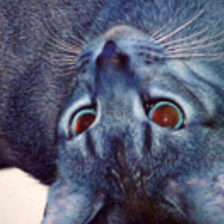

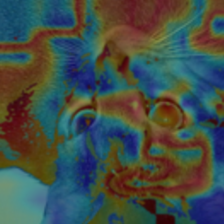

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

device = "cpu"
model = model.to(device)
sample = sample.to(device)

attention_rollout = Hook(model=model)
mask = attention_rollout(sample)
name = "attention_rollout_{}.png".format(sample_index)

np_img = np.array(sample)[:, :, ::-1] # Convert image to bgr
np_img = np.squeeze(np_img) # discard batch dim
np_img = np_img.transpose(1, 2, 0)
print(np_img.shape)

mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
heatmapshow = show_mask_on_image(np_img, mask)

np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())
np_img = (np_img * 255).astype(np.uint8)

super_imposed_img = cv2.addWeighted(heatmapshow, 0.3, np_img, 0.3, 0)
'''
cv2.imshow("Input Image", np_img)
cv2.imshow(name, mask)
'''
cv2_imshow(np_img)
cv2_imshow(super_imposed_img)

cv2.waitKey(-1)

In [ ]:
all_preds = []
all_labels = []

device = "cuda"
model = model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn import metrics
accuracy = metrics.accuracy_score(all_labels, all_preds)

In [ ]:
print('Accuracy Score: {:.2f}%'.format(accuracy * 100))

Accuracy Score: 5.48%
